In [ ]:
import csv
import codecs
import argparse
import os
from pathlib import Path
import pandas as pd
import sys, argparse
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import gc
from spacy.lang.en import English
import re
import string
from tqdm import tqdm
import numpy as np
from scipy.sparse import coo_matrix, vstack
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter
from bs4 import BeautifulSoup

In [ ]:
path = '/content/drive/MyDrive/DATA641 Final Project/nlp_project_data/umd_reddit_suicidewatch_dataset_v2/'

# **Functions**

In [ ]:
def normalize_tokens(tokenlist):
    normalized_tokens = [token.lower().replace('_','+') for token in tokenlist   # lowercase, _ => +
                             if re.search('[^\s]', token) is not None            # ignore whitespace tokens
                             and not token.startswith("@")                       # ignore  handles
                        ]
    return normalized_tokens    

def ngrams(tokens, n):
    return [tokens[i:i+n] for i in range(len(tokens)-n+1)]

def filter_punctuation_bigrams(ngrams):
    punct = string.punctuation
    return [ngram   for ngram in ngrams   if ngram[0] not in punct and ngram[1] not in punct]

def filter_stopword_bigrams(ngrams, stopwords):
    result = [ngram   for ngram in ngrams   if ngram[0] not in stopwords and ngram[1] not in stopwords]
    return result

In [ ]:
def convert_text_into_features(X, stopwords_arg, analyzefn="word", range=(1,1)):
    training_vectorizer = CountVectorizer(stop_words=stopwords_arg,
                                          analyzer=analyzefn,
                                          lowercase=True,
                                          ngram_range=range)
    X_features = training_vectorizer.fit_transform(X)
    return X_features, training_vectorizer

def convert_lines_to_feature_strings(lines, stopwords, remove_stopword_bigrams=True):

    print(" Converting from raw text to unigram and bigram features")
    if remove_stopword_bigrams:
        print(" Includes filtering stopword bigrams")
        
    print(" Initializing")
    nlp          = English(parser=False)
    all_features = []
    print(" Iterating through documents extracting unigram and bigram features")
    for line in tqdm(lines):
        
        # Get spacy tokenization and normalize the tokens
        spacy_analysis    = nlp(line)
        spacy_tokens      = [token.orth_ for token in spacy_analysis]
        normalized_tokens = normalize_tokens(spacy_tokens)

        # Collect unigram tokens as features
        # Exclude unigrams that are stopwords or are punctuation strings (e.g. '.' or ',')
        unigrams          = [token   for token in normalized_tokens
                                 if token not in stopwords and token not in string.punctuation]

        # Conjoin the feature lists and turn into a space-separated string of features.
        # E.g. if unigrams is ['coffee', 'cup'] and bigrams is ['coffee_cup', 'white_house']
        # then feature_string should be 'coffee cup coffee_cup white_house'

        unigrams = " ".join(unigrams)
        feature_string = unigrams 

        # Add this feature string to the output
        all_features.append(feature_string)


    print(" Feature string for first document: '{}'".format(all_features[0]))
        
    return all_features

def most_informative_features(vectorizer, classifier, n=20):
    # Adapted from https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers#11116960
    feature_names       = vectorizer.get_feature_names()
    coefs_with_features = sorted(zip(classifier.coef_[0], feature_names))
    top                 = zip(coefs_with_features[:n], coefs_with_features[:-(n + 1):-1])
    for (coef_1, feature_1), (coef_2, feature_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, feature_1, coef_2, feature_2))

In [ ]:
def load_stopwords(filename):
    stopwords = []
    with codecs.open(filename, 'r', encoding='ascii', errors='ignore') as fp:
        stopwords = fp.read().split('\n')
    return set(stopwords)

stopwords = load_stopwords(path+'mallet_en_stoplist.txt')   

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]/,.!?]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

# **Loading Data**

In [ ]:
crowd_train = pd.read_csv(path+'crowd/train/crowd_train.csv')
task_A_train = pd.read_csv(path+'crowd/train/task_A_train.posts.csv')
task_B_train = pd.read_csv(path+'crowd/train/task_B_train.posts.csv')
task_C_train = pd.read_csv(path+'crowd/train/task_B_train.posts.csv')
shared_task_train = pd.read_csv(path+'crowd/train/shared_task_posts.csv')

In [ ]:
crowd_test = pd.read_csv(path+'crowd/test/crowd_test.csv')
task_A_test = pd.read_csv(path+'crowd/test/task_A_test.posts.csv')
task_B_test = pd.read_csv(path+'crowd/test/task_B_test.posts.csv')
task_C_test = pd.read_csv(path+'crowd/test/task_B_test.posts.csv')
shared_task_test = pd.read_csv(path+'crowd/test/shared_task_posts_test.csv')

In [ ]:
label = np.array(['a','b','c','d'])
c = np.array(['Negative','Negative','Negative','Positive'])

d = np.vstack([label,c])

df_class = pd.DataFrame(data=d.T,columns=['label','class'])

df_class

,label,class
0,a,Negative
1,b,Negative
2,c,Negative
3,d,Positive


# **Task - only Suicide Watch**

In [ ]:
df_A_train = shared_task_train[shared_task_train['subreddit'] == 'SuicideWatch']
df_A_train = df_A_train.dropna()

In [ ]:
df_A_train = pd.merge(df_A_train,crowd_train,on='user_id')

df_A_train = pd.merge(df_A_train,df_class,on='label')

In [ ]:
df_A_test = shared_task_test[shared_task_test['subreddit'] == 'SuicideWatch']
df_A_test = df_A_test.dropna()

df_A_test = pd.merge(df_A_test,crowd_test,on='user_id')

df_A_test['label'] = df_A_test['raw_label']

df_A_test = pd.merge(df_A_test,df_class,on='label')


In [ ]:
X_train = convert_lines_to_feature_strings(df_A_train['post_body'],stopwords)

 Converting from raw text to unigram and bigram features
 Includes filtering stopword bigrams
 Initializing


  0%|          | 3/847 [00:00<00:28, 29.78it/s]

 Iterating through documents extracting unigram and bigram features


100%|██████████| 847/847 [00:25<00:00, 33.03it/s]

 Feature string for first document: 'party fun ... smoke ... n't remember fucking hurt 's 's compare pain inside things ... people n't sad beacuse talk problems ... fine okey .. people cool person confident ... fucking wrong scar real ... glad ... opening hand ... 's head ... witness depression ... things real ... scar 21 male ... feel 80 ... wanted share thoughts ..'


In [ ]:
X_train, training_vectorizer = convert_text_into_features(X_train,stopwords)

In [ ]:
X_test = convert_lines_to_feature_strings(df_A_test['post_body'],stopwords)
X_test = training_vectorizer.transform(X_test)

 Converting from raw text to unigram and bigram features
 Includes filtering stopword bigrams
 Initializing


  2%|▏         | 4/181 [00:00<00:05, 31.47it/s]

 Iterating through documents extracting unigram and bigram features


100%|██████████| 181/181 [00:05<00:00, 32.29it/s]

 Feature string for first document: 'n't hand 've told stay alive persevere life hand blowing brains ending matter die accept'


In [ ]:
data_A = pd.concat([df_A_train,df_A_test],axis=0)

In [ ]:
x = convert_lines_to_feature_strings(data_A['post_body'],stopwords)

 Converting from raw text to unigram and bigram features
 Includes filtering stopword bigrams
 Initializing


  0%|          | 3/1028 [00:00<00:34, 29.73it/s]

 Iterating through documents extracting unigram and bigram features


100%|██████████| 1028/1028 [00:31<00:00, 33.00it/s]

 Feature string for first document: 'party fun ... smoke ... n't remember fucking hurt 's 's compare pain inside things ... people n't sad beacuse talk problems ... fine okey .. people cool person confident ... fucking wrong scar real ... glad ... opening hand ... 's head ... witness depression ... things real ... scar 21 male ... feel 80 ... wanted share thoughts ..'


### **Logistic Regression**

In [ ]:
lr_classifier = LogisticRegression(solver='liblinear')
lr_classifier.fit(X_train, df_A_train['class'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
most_informative_features(training_vectorizer,lr_classifier,20)

	-1.4434	url            		0.9774	cut            
	-0.7982	advice         		0.8646	plan           
	-0.7866	sad            		0.8600	world          
	-0.7814	hours          		0.7978	knife          
	-0.7712	phone          		0.7557	upset          
	-0.7516	situation      		0.7517	enjoy          
	-0.7421	beat           		0.7400	part           
	-0.7199	afraid         		0.7280	alive          
	-0.7120	idea           		0.7081	throat         
	-0.6997	loans          		0.6605	option         
	-0.6989	throwaway      		0.6507	finally        
	-0.6834	male           		0.6119	lot            
	-0.6623	year           		0.6115	mess           
	-0.6492	recently       		0.6066	ready          
	-0.6378	friend         		0.5984	gon            
	-0.6263	convince       		0.5975	anymore        
	-0.6008	reasons        		0.5932	listening      
	-0.5922	early          		0.5929	pain           
	-0.5799	found          		0.5886	perfect        
	-0.5731	quote          		0.5811	tired          


In [ ]:
lr_classifier.score(X_test,df_A_test['class'])

0.5524861878453039

In [ ]:
X_features,_ = convert_text_into_features(x,stopwords)

In [ ]:
accuracy_scores = cross_val_score(lr_classifier, X_features, 
                                  data_A['class'],cv= 3)
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores, np.mean(accuracy_scores), np.std(accuracy_scores)))

accuracy scores = [0.60641399 0.56851312 0.56432749], mean = 0.5797515330275803, stdev = 0.018930487032098688


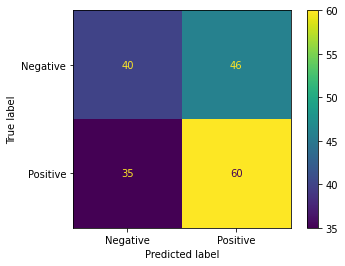

In [ ]:
metrics.plot_confusion_matrix(lr_classifier,X_test,df_A_test['class'])

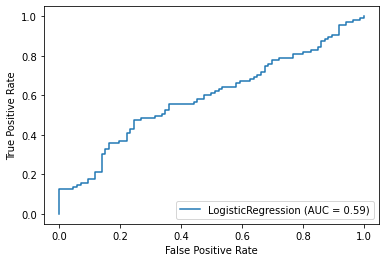

In [ ]:
metrics.plot_roc_curve(lr_classifier, X_test, df_A_test['class'])

### **Decision Trees**

In [ ]:
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X_train,df_A_train['class'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
tree.score(X_test,df_A_test['class'])

0.5193370165745856

In [ ]:
accuracy_scores = cross_val_score(tree, X_features, 
                                  data_A['class'],cv= 3)
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores, np.mean(accuracy_scores), np.std(accuracy_scores)))

accuracy scores = [0.65014577 0.52478134 0.53216374], mean = 0.5690302854642274, stdev = 0.05743643821708137


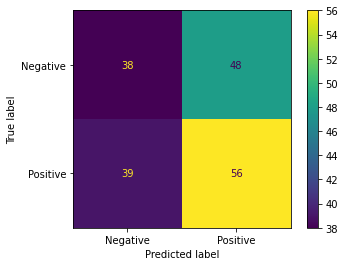

In [ ]:
metrics.plot_confusion_matrix(tree,X_test,df_A_test['class'])

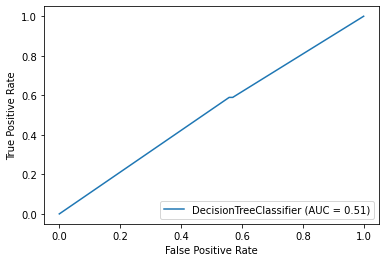

In [ ]:
metrics.plot_roc_curve(tree, X_test, df_A_test['class'])

# **Task - everything**

In [ ]:
df_B_train = shared_task_train
df_B_train = df_B_train.dropna()
df_B_train = pd.merge(df_B_train,crowd_train,on='user_id')
df_B_train = pd.merge(df_B_train,df_class, on = 'label')

df_B_train

,post_id,user_id,timestamp,subreddit,post_title,post_body,label,class
0,wfimt,22002,1342075703,GetMotivated,[real] motivation,This is my first post on reddit. Some time ago...,a,Negative
1,1bsqv3,22002,1365261010,leagueoflegends,simple question about transfering acc to anoth...,Hi.. What will happen with my ranked rating? I...,a,Negative
2,1dr0xf,22002,1367787358,leagueoflegends,simple question: Did you get unnbaned?,Hi. Simple question. Did you get unban from a ...,a,Negative
3,1e0noi,22002,1368125785,leagueoflegends,I can't win. Why... and it's noy my fault.,Hi... Am playing at Eu west... am diamond 5 ri...,a,Negative
4,1f0y6g,22002,1369483647,leagueoflegends,Diamond 5. Mrr rest,If i will switch server to EU and then go back...,a,Negative
...,...,...,...,...,...,...,...,...
16595,22syfw,40424,1397246842,Spanish,What is present progressive in this?,I am not understanding this. If i can get a li...,b,Negative
16596,2ftbnr,40424,1410190045,relationships,Me [28 M] with my GF [25 F] duration 2.5 years...,So my girlfriend has been getting mad at me re...,b,Negative
16597,2go4vz,40424,1410969771,MUTCoinSelling,Looking to buy elites and coins for XBOX one,I can do pay pal and amazon. Msg me and we can...,b,Negative
16598,2tg29c,40424,1422048216,baltimore,Where is the best place to get a leather couch...,My roommates cat scratched up my leather couch...,b,Negative


In [ ]:
df_B_test = shared_task_test
df_B_test = df_B_test.dropna()
df_B_test = pd.merge(df_B_test,crowd_test,on='user_id')
df_B_test['label'] = df_B_test['raw_label']
df_B_test = pd.merge(df_B_test,df_class, on = 'label')

df_B_test

,post_id,user_id,timestamp,subreddit,post_title,post_body,raw_label,label,class
0,lqc87,22411,1319673820,SuicideWatch,"Is it ""Stronger"" to kill yourself or stay alive?","I mean really, I think about it, I don't want ...",c,c,Negative
1,lqleq,22411,1319688687,AskReddit,Is it me or my job?,I'm not sure if this is in the right place but...,c,c,Negative
2,lxaor,22411,1320205091,SuicideWatch,"Not entirely sure where this belongs, But you ...",So where to begin... So I have facets of my li...,c,c,Negative
3,m47u6,22411,1320714594,theoffice,I think we see to more of Creed.,"Seriously he needs more airtime, cause he is c...",c,c,Negative
4,m4fit,22411,1320726045,r4r,(M4a) Drinking buddies on eastern long island,I'm on eastern long island and have never been...,c,c,Negative
...,...,...,...,...,...,...,...,...,...
4901,2bv6hp,2198,1406477835,SuicideWatch,"Large rant of suicidal thoughts, beware! **Not...","First, let me start by saying that I'm trained...",b,b,Negative
4902,2p1h67,2198,1418352696,depression,"Lonely, feeling like I'm sinking further into ...","A little about me: I'm a female, 24. I have ba...",b,b,Negative
4903,2pmtg6,2198,1418863397,selfharm,Feeling utterly worthless and so ridiculously ...,I need help. I need not to self harm. I've res...,b,b,Negative
4904,2sg3cf,2198,1421272482,depression,Why fucking try?,Took me all week to get out of bed and be moti...,b,b,Negative


In [ ]:
x_b = convert_lines_to_feature_strings(df_B_train['post_body'],stopwords)

 Converting from raw text to unigram and bigram features
 Includes filtering stopword bigrams
 Initializing


100%|██████████| 16600/16600 [08:13<00:00, 33.62it/s]

 Iterating through documents extracting unigram and bigram features
 Feature string for first document: 'post reddit time ago wanted change life wanted fit wanted seduce beatiful womens wanted pass exams words real motivation dosen't movies watched books read 3 years realize moring siting famous people monument thinking real motivation perspective life literally change aspects life motivation fucking soul consciousness person works place dont person fit dont person person girls moment life realize hammer face soul cry beacuse person explode nuklear bomb motivation person person reflection literally create road succes time ... fat soo fat nt „ wanted ” run run ... mater matter long 6 months run 5 minutes days ago make test ... run 20 minutes ... 30 minutes ... 40 minutes broke chains run 60 minutes time life tired hell people person anymore created tears sweat feeling god messiah guys website love awesome place days write'


In [ ]:
X_train_b, training_vectorizer_b = convert_text_into_features(x_b,stopwords)

In [ ]:
X_test_b =  convert_lines_to_feature_strings(df_B_test['post_body'],stopwords)
X_test_b_features = training_vectorizer_b.transform(X_test_b)

 Converting from raw text to unigram and bigram features
 Includes filtering stopword bigrams
 Initializing


  0%|          | 3/4906 [00:00<03:16, 24.99it/s]

 Iterating through documents extracting unigram and bigram features


100%|██████████| 4906/4906 [02:26<00:00, 33.60it/s]


 Feature string for first document: 'n't hand 've told stay alive persevere life hand blowing brains ending matter die accept'


### **Logistic Regression**

In [ ]:
lr_classifier_b = LogisticRegression(solver='liblinear')
lr_classifier_b.fit(X_train_b, df_B_train['class'])

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
most_informative_features(training_vectorizer_b,lr_classifier_b,20)

	-0.1189	url            		0.0969	ca             
	-0.0911	bike           		0.0856	feel           
	-0.0712	great          		0.0832	voices         
	-0.0600	guys           		0.0646	life           
	-0.0510	hey            		0.0588	anymore        
	-0.0503	advice         		0.0515	meds           
	-0.0469	pretty         		0.0416	home           
	-0.0463	post           		0.0405	dimension      
	-0.0449	issue          		0.0404	family         
	-0.0438	fun            		0.0392	kill           
	-0.0422	team           		0.0377	sick           
	-0.0422	free           		0.0358	war            
	-0.0392	find           		0.0352	job            
	-0.0388	thing          		0.0348	psn            
	-0.0381	high           		0.0348	suicide        
	-0.0366	damage         		0.0345	told           
	-0.0361	water          		0.0344	friends        
	-0.0357	thoughts       		0.0343	medication     
	-0.0351	show           		0.0342	years          
	-0.0347	nt             		0.0340	house          


In [ ]:
lr_classifier_b.score(X_test_b_features,df_B_test['class'])

0.5774561761108846

In [ ]:
x_features_b = vstack([X_train_b,X_test_b_features])
data_B = pd.concat([df_B_train,df_B_test],axis=0)

In [ ]:
accuracy_scores_b = cross_val_score(lr_classifier_b, x_features_b, data_B['class'],cv= 3)
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores_b, 
                                                           np.mean(accuracy_scores_b), 
                                                           np.std(accuracy_scores_b)))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


accuracy scores = [0.54163761 0.55795787 0.53166853], mean = 0.5437546691089779, stdev = 0.010836478906021374


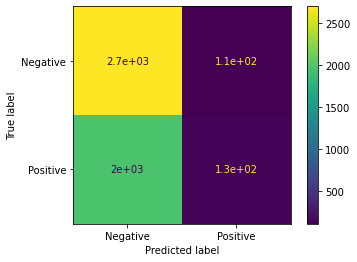

In [ ]:
metrics.plot_confusion_matrix(lr_classifier_b,X_test_b_features,df_B_test['class'])

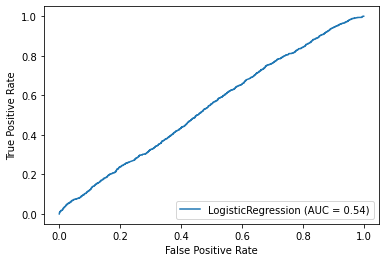

In [ ]:
metrics.plot_roc_curve(lr_classifier_b, X_test_b_features,df_B_test['class'])

### **Decision Trees**

In [ ]:
tree_b = DecisionTreeClassifier(criterion='entropy')
tree_b.fit(X_train_b, df_B_train['class'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
tree_b.score(X_test_b_features,df_B_test['class'])

0.5287403179779862

In [ ]:
accuracy_scores = cross_val_score(tree_b, x_features_b, data_B['class'],cv= 3)
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores_b, 
                                                           np.mean(accuracy_scores_b), 
                                                           np.std(accuracy_scores_b)))

accuracy scores = [0.54163761 0.55795787 0.53166853], mean = 0.5437546691089779, stdev = 0.010836478906021374


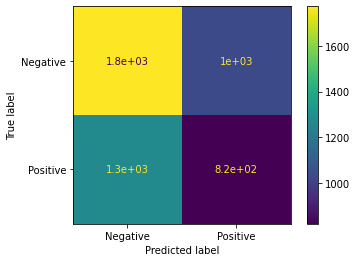

In [ ]:
metrics.plot_confusion_matrix(tree_b,X_test_b_features,df_B_test['class'])

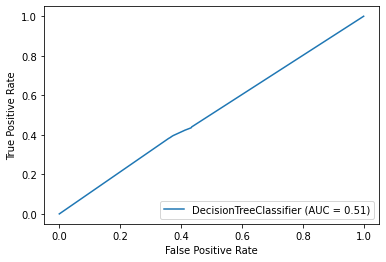

In [ ]:
metrics.plot_roc_curve(tree_b, X_test_b_features,df_B_test['class'])